<a href="https://colab.research.google.com/github/vperezguti/Resp-Experto-data---caso-practico/blob/main/Modelo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np

#Para la codificación y semaración de datos en datos de entramiento y validación
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Creación de los modelos Tensorflow Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

#Mostrar las imágenes
import matplotlib.pyplot as plt

#La BD de imágenes la tendremos guardada en nuestro drive de google
from google.colab import drive
drive.mount('/content/drive')

folder_dir = '/content/drive/MyDrive/Curso Data Science/mi_proyecto/images'
import random

Mounted at /content/drive


In [ ]:
#Donde tenemos guardados los datos de entrenamiento
data_dir = '/content/drive/MyDrive/Curso Data Science/mi_proyecto/images'

#Configuramos la medida de las imágenes
img_height = 256
img_width = 256
batch_size = 32

#Datos de entrenamiento, el 80%    
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
    
#Datos de valiación, el 20%    
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

#Veamos las clases que tenemos
class_names = train_ds.class_names

print(class_names)

Found 1148 files belonging to 10 classes.
Using 919 files for training.
Found 1148 files belonging to 10 classes.
Using 229 files for validation.
['Agaricus campestris', 'Amanita muscaria', 'Amanita phalloides', 'Boletus edulis', 'Lepista nuda', 'Macrolepiota procera', 'Marasmius oreades', 'Pleurotus ostreatus', 'Rubroboletus satanas', 'Tricholoma portentosum']


# Vamos a visualizar imágenes. 
Las primeras 9

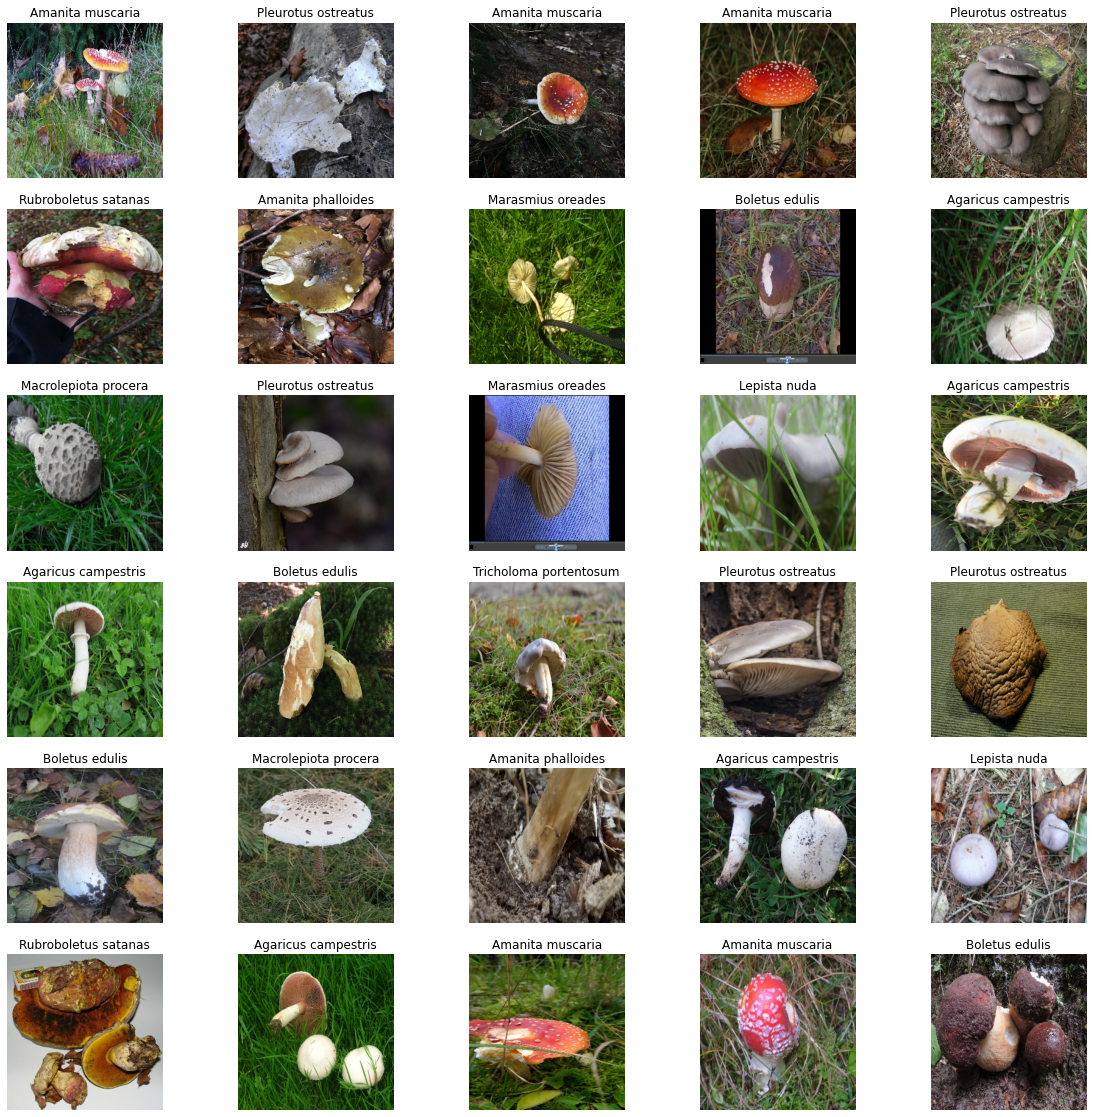

In [ ]:
#Para hacernos una idea de los datos que vamos a tratar visualizamos algunas imágenes, en este caso vemos 30
plt.figure(figsize=(20,20))
for images,labels in train_ds.take(1):
  for i in range(30):
    ax = plt.subplot(6,5,i+1) #Mostramos en un cuadro e 6X5
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
#Con el fin de mejorar el rendimiento, utilizamos el AUTOTUNE
#Se utiliza la precarga en búfer para cargar imágenes desde el disco sin que la entrada/salida se bloquee.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Primer modelo: modelo sencillo
Le creamos con tres capas convolucionales


In [ ]:
#Crearemos el modelo con tres convoluciones
num_classes = len(class_names)

model1 = Sequential([
#Reescalamos las imágenes para estandarizarlas en el intervalo (0,1)
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),   
#Primera convolución, 16 filtros de salida, tamaño de kernel 3, 
# Padding 'same' da como resultado un relleno con ceros uniformemente a la izquierda/derecha o arriba/abajo de la entrada. 
# La función de activuación es 'relu'
  Conv2D(16, 3, padding='same', activation='relu'), 
#La capa de agrupación  
  MaxPooling2D(),
#Segunda convolución, 32 filtros de salida
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
#Segunda convolución, 64 filtros de salida  
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
#Capa de aplanamiento
  Flatten(),
#Capa densa para conectar  
  Dense(128, activation='relu'),
#Otra capa densa para indicar el número de clases  
  Dense(num_classes)
])

In [ ]:
#Compilamos el modelo, optimizador adam
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Resúmen del modelo
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Entrenemos el modelo!!

In [ ]:
#Compilamos el modelo con 10 épocas
epochs1=10
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs1
)

Epoch 1/10
29/29 [==============================] - 53s 2s/step - loss: 2.1328 - accuracy: 0.2492 - val_loss: 2.0259 - val_accuracy: 0.2882
Epoch 2/10
29/29 [==============================] - 28s 974ms/step - loss: 1.8402 - accuracy: 0.3613 - val_loss: 1.8006 - val_accuracy: 0.3799
Epoch 3/10
29/29 [==============================] - 28s 983ms/step - loss: 1.6129 - accuracy: 0.4483 - val_loss: 1.7325 - val_accuracy: 0.4017
Epoch 4/10
29/29 [==============================] - 28s 983ms/step - loss: 1.3434 - accuracy: 0.5593 - val_loss: 1.7946 - val_accuracy: 0.3843
Epoch 5/10
29/29 [==============================] - 31s 1s/step - loss: 1.0543 - accuracy: 0.6518 - val_loss: 1.8183 - val_accuracy: 0.4323
Epoch 6/10
29/29 [==============================] - 29s 988ms/step - loss: 0.6907 - accuracy: 0.7845 - val_loss: 1.7748 - val_accuracy: 0.4192
Epoch 7/10
29/29 [==============================] - 29s 994ms/step - loss: 0.4241 - accuracy: 0.8727 - val_loss: 1.8526 - val_accuracy: 0.4891
Epoch

## VISUALIZAR LOS RESULTADOS
Vamos a visualizar lor resultados

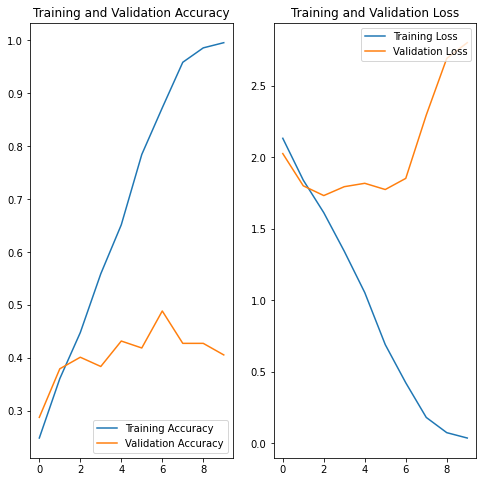

In [ ]:
#Visualizamos los parámetros de ajuste y la función de pérdida
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs_range1 = range(epochs1)

#Lo mostramos en dos gráficos
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range1, acc1, label='Training Accuracy')
plt.plot(epochs_range1, val_acc1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range1, loss1, label='Training Loss')
plt.plot(epochs_range1, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Los gráficos muestran que la precisión de los datos de entrenmiento y los de validación se diferencian mucho y el modelo ha alcanzado solo un 40% de precisión en los datos de validación. Tendremos que mejorar el modelo ya que parece que hay overfitting, utilizaremos el data augmentarion y añadiremos dopout al modelo 

**Leemos el modelo1**

In [ ]:
# Load the Model back from file
#import pickle
#Pkl_Filename = "Pickle_modelo1.pkl"  
#with open(Pkl_Filename, 'rb') as file:  
#    Pickled_LR_Model = pickle.load(file)

#Pickled_LR_Model

## Algunos ejemplos de predicción
Hemos buscado por internet algunas fotos para ver si qué tal predice


In [ ]:
# Creamos un diccionario con las fotos
datos_test = {'Agaricus campestris': 'https://www.mycodb.fr/photos/Agaricus_campestris_2003_dr_1.jpg', 
              'Macrolepiota Procera': 'https://www.mycodb.fr/photos/Macrolepiota_procera_2014_df_1.jpg', 
              'Amanita muscaria': 'https://www.mycodb.fr/photos/Amanita_muscaria_2005_ov_2.jpg', 
              'Amanita Phaloides': 'https://www.mycodb.fr/photos/Amanita_phalloides_2011_jpa_1.jpg', 
              'Boletus edulis': 'https://www.mycodb.fr/photos/Boletus_edulis_2007_ov_1.jpg', 
              'Lepista nuda': 'https://www.mycodb.fr/photos/Lepista_nuda_2019_db_1.jpg', 
              'Marasmius oreades': 'https://www.mycodb.fr/photos/Marasmius_oreades_2000_dr_1.jpg', 
              'Pleurotus ostreatus': 'https://www.mycodb.fr/photos/Pleurotus_ostreatus_2015_hm_1.jpg', 
              'Tricholoma portentosum': 'https://www.mycodb.fr/photos/Tricholoma_portentosum_2014_td_3.jpg', 
              'Rubroboletus satanas': 'https://www.mycodb.fr/photos/Rubroboletus_satanas_2006_ar_1.jpg'}

In [ ]:
#Crearemos una función para el cálculo 
def predict_seta(img_height, img_width, clases, modelo, img_url):
  img_path = tf.keras.utils.get_file('mushroom_image'+str(random.randint(0, 999)), origin=img_url)

  img = tf.keras.preprocessing.image.load_img(
      img_path, target_size=(img_height, img_width, 3)
  )

#plt.imshow(img)

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create a batch

  predictions = modelo.predict(img_array)

  predictions_sigmoid = tf.nn.sigmoid(predictions)
  score = tf.nn.softmax(predictions[0])

  return clases[np.argmax(score)], img

1/1 [==============================] - 0s 37ms/step


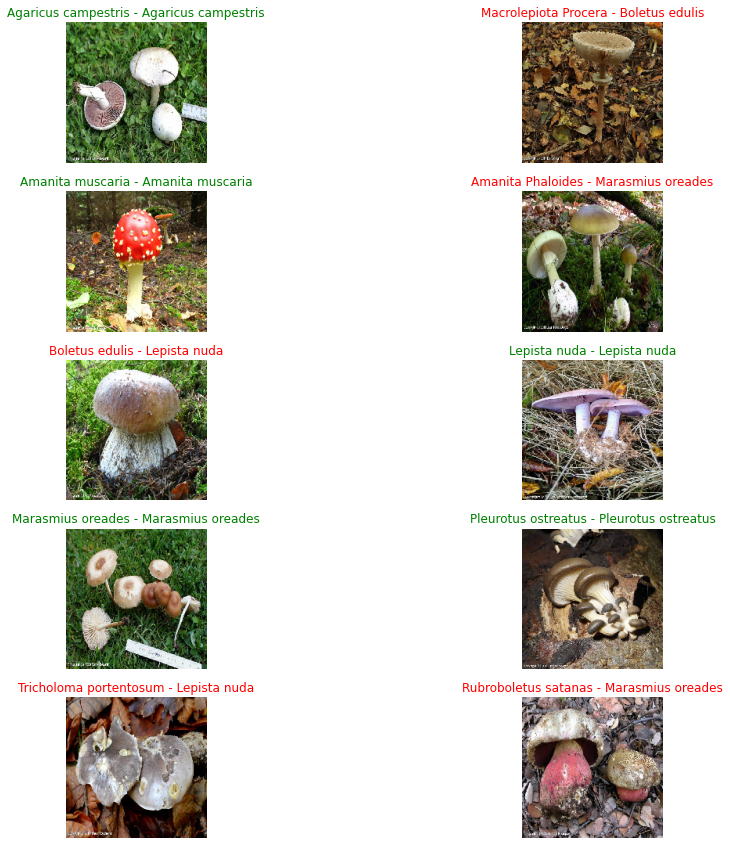

In [ ]:
#Vemos la prediccón
predict_dict1 = {}
plt.figure(figsize=(15,15))
i = 1
for nombre, url in datos_test.items():
  prediccion1 = predict_seta(img_height, img_width, class_names, model1, url)
  predict_dict1[nombre] = prediccion1[0]
  ax = plt.subplot(5,2,i)
  plt.imshow(prediccion1[1])
  if nombre == prediccion1[0]:
# Si se acierta la predicción, vemos el texto en verde
    plt.title(nombre+" - "+prediccion1[0], color = 'g')
  else:  
# Si se equivoca en la predicción, vemos el texto en rojo    
    plt.title(nombre+" - "+prediccion1[0], color = 'r')
  plt.axis("off")
  i += 1
#print(predict_dict)

**Código para grabar el modelo**


In [ ]:
#El siguiente código es para grabar el modelo
#import pickle
#Pkl_Filename = "Pickle_modelo1.pkl"  

#with open(Pkl_Filename, 'wb') as file:  
#    pickle.dump(model1, file)